In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
import torchmetrics
import lightning as L

In [2]:
model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
bert_tokenizer = BertTokenizer.from_pretrained(model)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
device

device(type='cuda')

In [4]:
df = pd.read_csv(r'datasets\extractedURLs\ranked_url_classes.csv')
df.dropna(inplace=True)
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}

In [5]:
chars = set([c for a in df.Address.values for c in ' '.join(bert_tokenizer.tokenize(a))])
vocab_dict = {c:i for i, c in enumerate(chars)}

In [6]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, dictionary, tokenizer, doc_token_length=256, doc_char_length=1024) -> None:
        super().__init__()
        self.doc_char_length = doc_char_length
        self.doc_teken_length = doc_token_length
        
        
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.dictionary = dictionary
        self.dict_keys = list(dictionary.keys())
        self.vocab_size = len(self.dictionary)
        self.tokenizer = tokenizer
        
        self.X = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        
        for i, doc in enumerate(X):
            tokens = self.tokenizer(doc)
            tokens.append(self.dict_keys[-1])
            doc = ' '.join(tokens)
            
            indices = torch.from_numpy(np.array([self.dictionary[t] for t in doc if t in self.dictionary], dtype=np.longlong))
            char_pad_size = max(self.doc_char_length - len(indices), 0)
            
            self.X[i] = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
            token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            self.token_indices[i] = token_indices
        
        
    def __getitem__(self, index):
        return self.X[index], self.y[index], self.token_indices[index]
        
    def __len__(self):
        return len(self.y)
        

In [21]:
class CharToToken(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super(CharToToken, self).__init__(*args, **kwargs)
        
    def forward(self, x, token_counts):
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        return x

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, kernel_size=[5, 5, 3, 3], seed=-1, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_char_count = max_char_count
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        # nn.init.normal_(self.embedding.weight)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=kernel_size[0], padding=kernel_size[0]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[1], padding=kernel_size[1]//2)
        
        self.chat_to_token = CharToToken()
        # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=kernel_size[2], padding=kernel_size[2]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[3], padding=kernel_size[3]//2)
        
        self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.chat_to_token(x, token_counts)
        # x = x.permute(0, 2, 1)
        # x1 = scatter_max(x,token_counts, dim=1)[0]
        # x2 = scatter_mean(x,token_counts, dim=1)
        # # x2 = scatter_sum(x,token_counts, dim=1)
        # # x2 = scatter_std(x,token_counts, dim=1)
        # x = torch.cat([x1, x2], dim=2)
        # # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        # x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [24]:
# X, y, token_counts = next(iter(test_dataloader))
# classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.2, num_out_features=len(class_id), kernel_size=[5, 5, 5, 3], seed=seed)
# classifier_torch_model(X, token_counts)

In [11]:

class ClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(ClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, token_count, *args, **kwargs):
        return self.model(x, token_count)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X, token_count)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X, token_count)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [12]:
from tqdm import tqdm
from torchmetrics.classification import accuracy, MulticlassF1Score, precision_recall, confusion_matrix, MulticlassHingeLoss
def calculate_metrics(cl_model):
    cm = confusion_matrix.MulticlassConfusionMatrix(len(class_id))
    pr = precision_recall.MulticlassPrecision(len(class_id))
    rec = precision_recall.MulticlassRecall(len(class_id))
    acc = accuracy.MulticlassAccuracy(len(class_id))
    f1 = MulticlassF1Score(len(class_id))

    y_pred = []
    y_true = []
    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y, tc in tqdm(test_dataloader):
        X = X.to(device)
        tc = tc.to(device)
        with torch.no_grad():
            y_p = cl_model(X, tc)
        y_pred.append(y_p.cpu())
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'accuracy: {acc(y_pred2, y_true2)}')
    print(f'precision: {pr(y_pred2, y_true2)}')
    print(f'recall: {rec(y_pred2, y_true2)}')
    print(f'f1 score: {f1(y_pred2, y_true2)}')
    print('================================')
    
    df_test2 = df_test.dropna()[:y_true.shape[0]]
    df_test2.Rank.shape
    correct_preds = (y_pred2 == y_true2) 
    print(f"mean of correct prediction ranks: {np.mean(df_test2.Rank.values[correct_preds])}")
    print(f"mean of wrong prediction ranks: {np.mean(df_test2.Rank.values[~correct_preds])}")
    print('================================')
    
    position_accs = []
    df_test2.index = np.arange(df_test2.shape[0])
    for i in range(1, 11):
        rnk = np.squeeze(np.argwhere(df_test2.Rank.values==i))
        # print(f'{i}: {len(rnk)}')
        ranked_acc = np.sum(np.array((y_true2[rnk] == y_pred2[rnk]).float()))/len(rnk)
        position_accs.append(ranked_acc)
        print(f'positive accuracy {i}: {ranked_acc:.3f}')
    print('================================')
    return torch.tensor(position_accs, dtype=torch.float32)

In [13]:
lr= 0.0036
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1

In [14]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)
train_dataset = CharacterandTokenLevelCustomDataset(df_train.Address.values, df_train.Topic.values, len(class_id), vocab_dict, bert_tokenizer.tokenize, doc_token_length=64, doc_char_length=256)
test_dataset = CharacterandTokenLevelCustomDataset(df_test.Address.values, df_test.Topic.values, len(class_id), vocab_dict, bert_tokenizer.tokenize, doc_token_length=64, doc_char_length=256)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [25]:
seed = 911
classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.2, num_out_features=len(class_id), kernel_size=[5, 5, 5, 3], seed=seed).to(device)
optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.00012)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
loss_func = torch.nn.BCEWithLogitsLoss()
classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
                                                    num_classes=len(class_id),
                                            learning_rate=lr,
                                            batch_size=batch_size,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            lr_scheduler=lr_scheduler,
                                            user_lr_scheduler=True
                                            ).to(device)

from lightning.pytorch.loggers import CSVLogger
import lightning as L

trainer = L.Trainer(
            # callbacks=callbacks,
            max_epochs=400,
            accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
            logger=CSVLogger(save_dir='logs/', name='log2'), 
        #     num_sanity_val_steps=0,
        #     default_root_dir='models\model2_word_embedding-256-2'
        )

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 231 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
231 K     Trainable params
0         Non-trainable params
231 K     Total params
0.925     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [27]:
calculate_metrics(classfier_lightning_model)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 11.28it/s]

accuracy: 0.7805492877960205
precision: 0.7803242802619934
recall: 0.7805492877960205
f1 score: 0.779547393321991
mean of correct prediction ranks: 5.414746543778802
mean of wrong prediction ranks: 5.856934306569343
positive accuracy 1: 0.804
positive accuracy 2: 0.790
positive accuracy 3: 0.818
positive accuracy 4: 0.814
positive accuracy 5: 0.793
positive accuracy 6: 0.757
positive accuracy 7: 0.770
positive accuracy 8: 0.745
positive accuracy 9: 0.754
positive accuracy 10: 0.726


tensor([0.8037, 0.7904, 0.8182, 0.8143, 0.7933, 0.7566, 0.7698, 0.7452, 0.7540,
        0.7262])

In [28]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
df1 = pd.read_csv(r'datasets\extractedURLs\ranked_url_classes.csv', encoding='utf-8')
df2 = pd.read_csv(r'datasets\extractedURLs\url_classes.csv', encoding='utf-8')
i = 0 
j = 0
distorted_count = 0
distorted_ranks = []
while i<len(df1) and j < len(df2):
    
    if df1.iloc[i].Address == df2.iloc[j].Address:
        pass
    elif i+1 < len(df1) and df1.iloc[i+1].Address == df2.iloc[j].Address:
        i += 1
    elif j+1 < len(df2) and df1.iloc[i].Address == df2.iloc[j+1].Address:
        j += 1
    else:
        k = 0
        addr1, addr2 = df1.iloc[i].Address, df2.iloc[j].Address
        if(similar(addr1, addr2)>0.85):
            distorted_count+=1
            distorted_ranks.append(df1.iloc[j].Rank)
        else:
            print('distance is more than one', i, j)
            break
        
    if df1.iloc[i].Topic != df2.iloc[j].Topic:
        print('Not Equal', i, j)
    i += 1
    j += 1
print(distorted_count)
i, j = i if i < len(df1) else 0, j if j < len(df2) else 0
print(i, df1.iloc[i].Address)
print(j, df2.iloc[j].Address)
print(similar(df1.iloc[i].Address, df2.iloc[j].Address))
print(f'distorted_count: {distorted_count}, distorted mean: {np.mean(distorted_ranks)}, total mean: {df1.Rank.mean()}')

66
0 https://en.wikipedia.org/wiki/Dunking
0 https://en.wikipedia.org/wiki/Dunking
1.0
distorted_count: 66, distorted mean: 5.606060606060606, total mean: 5.494105759514988


In [29]:
X, y, tc = next(iter(test_dataloader))
eb_model = trainer.model.model.eval()

In [30]:
from captum.attr import Lime, LimeBase
from captum.attr._core.lime import get_exp_kernel_similarity_function
from IPython.core.display import HTML, display
from captum._utils.models.linear_model import SkLearnLasso
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients

C:\Users\fardin\AppData\Local\Temp\ipykernel_21160\259572081.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [31]:
eb_model

CNN_for_Text(
  (embedding): Embedding(82, 64)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (chat_to_token): CharToToken()
  (conv3): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (globalpool): AdaptiveMaxPool1d(output_size=64)
  (fc1): Linear(in_features=4096, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=32, out_features=12, bias=True)
)

In [38]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []
dict_keys = list(vocab_dict.keys())
token_reference = TokenReferenceBase(reference_token_idx=1)
visualize_on_tokens = False
lig = LayerIntegratedGradients(eb_model, eb_model.chat_to_token if visualize_on_tokens else eb_model.embedding)
# ig = IntegratedGradients(eb_model)

def prepare_input_indices(doc, tokenizer, dictionary, dict_keys, doc_char_length):
    tokens = tokenizer(doc)
    tokens.append(dict_keys[-1])
    doc = ' '.join(tokens)
    characters = [t for t in doc if t in dictionary]
    
    indices = torch.from_numpy(np.array([dictionary[t] for t in doc if t in dictionary], dtype=np.longlong))
    char_pad_size = max(doc_char_length - len(indices), 0)
    
    input_tensor = torch.nn.functional.pad(indices[:doc_char_length], (0,char_pad_size))
    
    token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
    token_lengths[-1] -= 1
    token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
    token_indices = torch.nn.functional.pad(token_indices[:doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
    return input_tensor, token_indices, tokens, characters

def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            id_class[pred_ind],
                            id_class[label],
                            id_class[label],
                            attributions.sum(),
                            text,
                            delta))

def interpret_sentence(model, sentence, min_len = 256, label = 0, visualize_on_tokens=False):

    input_tensor, token_indices, text, characters = prepare_input_indices(sentence, bert_tokenizer.tokenize, vocab_dict, dict_keys, min_len)
        
    model.zero_grad()
    
    seq_length = min_len

    # predict
    # print(input_tensor.shape)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    token_indices = token_indices.unsqueeze(0).to(device)
    pred = torch.softmax(model(input_tensor, token_indices), dim=1).detach()
    pred_ind = torch.argmax(pred).item()

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0).to(device)

    # compute attributions and approximation delta using layer integrated gradients
    # print(input_tensor.dtype)
    # print(reference_indices.dtype)
    attributions_ig, delta = lig.attribute((input_tensor, token_indices), (reference_indices, token_indices), n_steps=500, return_convergence_delta=True, target=label)
    # attributions_ig, delta = ig.attribute((input_tensor, token_indices), target=11)
    print(f'true: {id_class[label]}({label}), pred: {id_class[pred_ind]}({pred_ind}), max delta: {delta}')
    
    print(f'text: {text}, attributions_ig: {attributions_ig.shape}, label: {label}, delta: {delta}')

    if visualize_on_tokens:
        add_attributions_to_visualizer(attributions_ig, text, pred[0,pred_ind], pred_ind, label, delta, vis_data_records_ig)
    else:
        add_attributions_to_visualizer(attributions_ig, characters, pred[0,pred_ind], pred_ind, label, delta, vis_data_records_ig)


In [39]:
torch.nn.functional.one_hot(torch.tensor(class_id[df_test.Topic.values[i]]), num_classes=12).detach().tolist()

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [40]:
vis_data_records_ig = []
for i in range(10):
    interpret_sentence(eb_model, df_test.Address.values[i], label=class_id[df_test.Topic.values[i]], visualize_on_tokens=visualize_on_tokens)
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)
html = _.data
with open(r'Visualizations\visualization_records\result.html', 'w') as f:
    f.write(html)

true: gardening(3), pred: gardening(3), max delta: tensor([0.0139], device='cuda:0', dtype=torch.float64)
text: ['https', ':', '/', '/', 'jo', '##hnt', '##he', '##plant', '##man', '.', 'com', '/', '2010', '/', '07', '/', '18', '/', '665', '/', 'q'], attributions_ig: torch.Size([1, 256, 64]), label: 3, delta: tensor([0.0139], device='cuda:0', dtype=torch.float64)
true: cats(2), pred: weather(11), max delta: tensor([0.0022], device='cuda:0', dtype=torch.float64)
text: ['https', ':', '/', '/', 'www', '.', 'p', '##cm', '##ag', '.', 'com', '/', 'how', '-', 'to', '/', 'good', '##bye', '-', 'light', '##ning', '-', 'cable', '-', 'how', '-', 'to', '-', 'prepare', '-', 'for', '-', 'your', '-', 'first', '-', 'us', '##b', '-', 'c', '-', 'i', '##phone', 'q'], attributions_ig: torch.Size([1, 256, 64]), label: 2, delta: tensor([0.0022], device='cuda:0', dtype=torch.float64)
true: cats(2), pred: weather(11), max delta: tensor([0.0009], device='cuda:0', dtype=torch.float64)
text: ['https', ':', '/', '/

In [68]:
with torch.no_grad():
    X = X.to(device)
    tc = tc.to(device)
    eb_model = eb_model.to(device)
    y_pred = torch.argmax(eb_model(X[:10], tc[:10]), dim=1)
    y_pred = y_pred.detach().cpu()
for i in range(10):
    print(f'y: {id_class[torch.argmax(y[i], dim=0).item()]}, y_pred: {id_class[y_pred[i].item()]}')

y: travel, y_pred: movies
y: music, y_pred: music
y: sports, y_pred: sports
y: history, y_pred: history
y: movies, y_pred: music
y: weather, y_pred: weather
y: basketball, y_pred: books
y: sports, y_pred: cats
y: books, y_pred: technology
y: cats, y_pred: cats


In [70]:
class EmbeddingCNN(nn.Module):
    
    def __init__(self, base_model, seed=-1, *args, **kwargs) -> None:
        super(EmbeddingCNN, self).__init__(*args, **kwargs)
        self.batch_size = base_model.batch_size
        self.max_char_count = base_model.max_char_count
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = base_model.embedding
        self.conv1 = base_model.conv1
        self.pool1 = base_model.pool1 
        self.conv2 = base_model.conv2 
        
        self.conv3 = base_model.conv3 
        self.conv4 = base_model.conv4 
        self.dropout = base_model.dropout
        self.globalpool = base_model.globalpool
       
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        return x

In [ ]:
# class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_char_count = max_char_count
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        # nn.init.normal_(self.embedding.weight)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [71]:
emb_cnn = EmbeddingCNN(eb_model, seed).eval().to(device)

In [72]:
X, y, tc = next(iter(test_dataloader))
X, y, tc = X.to(device), y.to(device), tc.to(device)
with torch.no_grad():
    output = emb_cnn(X, tc)
output = output.detach()
output.shape

torch.Size([1024, 64, 64])

In [73]:
X_a, tc_a, y_a = [], [], []
output_a = []
for X, y, tc in test_dataloader:
    print(tc.shape)
    with torch.no_grad():
        output_a.append(emb_cnn(X.to(device), tc.to(device)).detach())
    X_a.append(X)
    tc_a.append(tc)
    y_a.append(y)
X_a = torch.cat(X_a, dim=0)
tc_a = torch.cat(tc_a, dim=0)
y_a = torch.cat(y_a, dim=0)
output_a = torch.cat(output_a, dim=0)
X_a.shape, tc_a.shape, y_a.shape, output_a.shape

torch.Size([1024, 256])
torch.Size([1024, 256])
torch.Size([1024, 256])


(torch.Size([3072, 256]),
 torch.Size([3072, 256]),
 torch.Size([3072, 12]),
 torch.Size([3072, 64, 64]))

In [74]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

In [75]:
# X = output_a

In [76]:
X = torch.empty((output_a.shape[0], output_a.shape[1] * output_a.shape[2]), dtype=torch.float32)
for i in range(output_a.shape[0]):
    X[i] = output_a[i].reshape((-1))

In [81]:
pca = PCA(n_components=1000)
sample_pca = pca.fit_transform(X.detach().numpy())

In [97]:
kpca = KernelPCA(n_components=1000, kernel='poly')
sample_pca = pca.fit_transform(X.detach().numpy())

In [98]:
# tsne1 = TSNE(n_components=2, verbose=2, early_exaggeration=12, perplexity=3000, n_iter=1000, learning_rate=1000)#, init='pca')
tsne2 = TSNE(n_components=2, early_exaggeration=12, random_state=0, verbose=2, perplexity=10, n_iter=4000)

# sample_tsne1 = tsne1.fit_transform(X.detach().numpy())
sample_tsne2 = tsne2.fit_transform(sample_pca)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3072 samples in 0.012s...
[t-SNE] Computed neighbors for 3072 samples in 0.953s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3072
[t-SNE] Computed conditional probabilities for sample 2000 / 3072
[t-SNE] Computed conditional probabilities for sample 3000 / 3072
[t-SNE] Computed conditional probabilities for sample 3072 / 3072
[t-SNE] Mean sigma: 1.603054
[t-SNE] Computed conditional probabilities in 0.065s
[t-SNE] Iteration 50: error = 88.2303696, gradient norm = 0.0399694 (50 iterations in 1.046s)
[t-SNE] Iteration 100: error = 82.6478729, gradient norm = 0.0059365 (50 iterations in 0.813s)
[t-SNE] Iteration 150: error = 81.9467010, gradient norm = 0.0020990 (50 iterations in 0.905s)
[t-SNE] Iteration 200: error = 81.7686920, gradient norm = 0.0014070 (50 iterations in 0.986s)
[t-SNE] Iteration 250: error = 81.7121735, gradient norm = 0.0008963 (50 iterations in 0.856s)
[t-SNE] KL divergence after 250 iterati

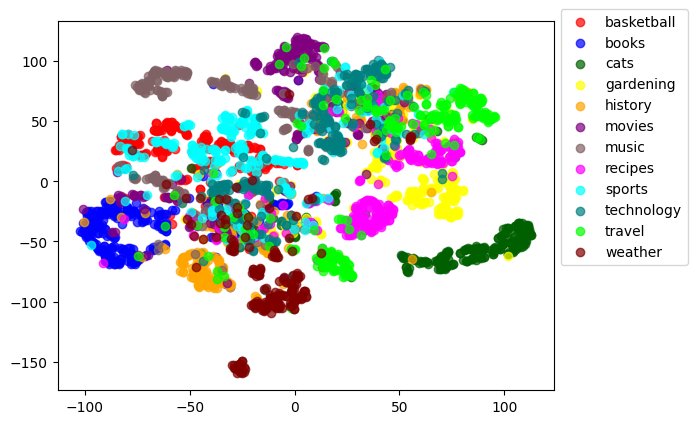

In [99]:
colors = np.array([
    (255, 0, 0),    # Red
    (0, 0, 255),    # Blue
    (0, 96, 0),    # Green
    (255, 255, 0),  # Yellow
    (255, 165, 0),  # Orange
    (128, 0, 128),  # Purple
    (128, 98, 101),  # Pink
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cyan
    (0, 128, 128),  # Teal
    (0, 255, 0),    # Lime
    (128, 0, 0)     # Maroon
])/255.
labels = torch.argmax(y_a, dim=1).numpy()
for i in range(len(id_class)):
    stsne = sample_tsne2[labels==i]
    tsne_x = stsne[:,0]
    tsne_y = stsne[:,1]
    plt.scatter(tsne_x, tsne_y, c=[colors[i]], label=id_class[i], alpha=0.7)

plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

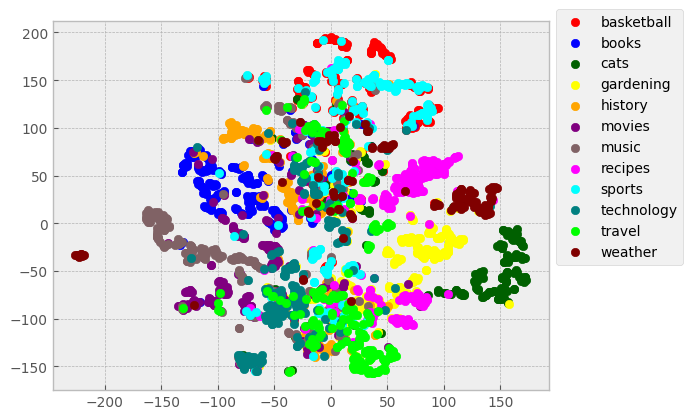

In [200]:
colors = np.array([
    (255, 0, 0),    # Red
    (0, 0, 255),    # Blue
    (0, 96, 0),    # Green
    (255, 255, 0),  # Yellow
    (255, 165, 0),  # Orange
    (128, 0, 128),  # Purple
    (128, 98, 101),  # Pink
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cyan
    (0, 128, 128),  # Teal
    (0, 255, 0),    # Lime
    (128, 0, 0)     # Maroon
])/255.
labels = torch.argmax(y_a, dim=1).numpy()
for i in range(len(id_class)):
    stsne = sample_tsne2[labels==i]
    tsne_x = stsne[:,0]
    tsne_y = stsne[:,1]
    plt.scatter(tsne_x, tsne_y, c=[colors[i]], label=id_class[i])

plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

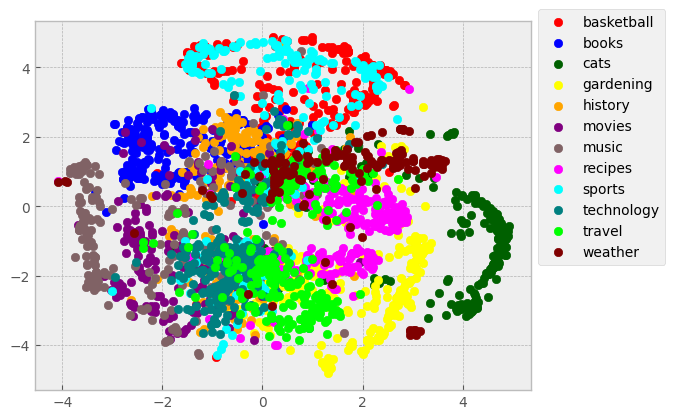

In [157]:
colors = np.array([
    (255, 0, 0),    # Red
    (0, 0, 255),    # Blue
    (0, 96, 0),    # Green
    (255, 255, 0),  # Yellow
    (255, 165, 0),  # Orange
    (128, 0, 128),  # Purple
    (128, 98, 101),  # Pink
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cyan
    (0, 128, 128),  # Teal
    (0, 255, 0),    # Lime
    (128, 0, 0)     # Maroon
])/255.
labels = torch.argmax(y_a, dim=1).numpy()
for i in range(len(id_class)):
    stsne = sample_tsne1[labels==i]
    tsne_x = stsne[:,0]
    tsne_y = stsne[:,1]
    plt.scatter(tsne_x, tsne_y, c=[colors[i]], label=id_class[i])

plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


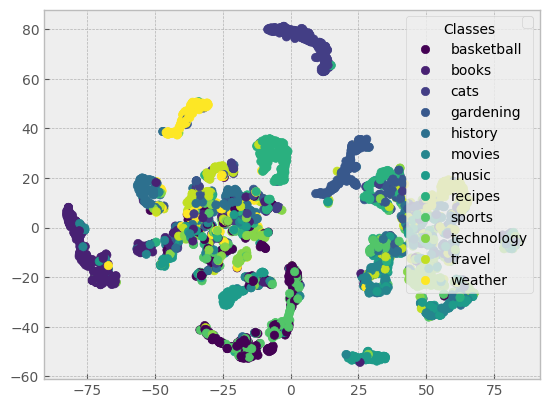

In [131]:
tsne_x = sample_tsne2[:,0]
tsne_y = sample_tsne2[:,1]
# plt.style.use('seaborn-v0_8-bright')
fig = plt.figure()
ax = fig.add_subplot()
color  = torch.argmax(y_a, dim=1).numpy()
colors = cm.rainbow(color/ (np.max(color)*1.0))
labels = np.array([id_class[c] for c in color])
scatter = ax.scatter(tsne_x, tsne_y, c=color)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
for i in id_class: legend1.get_texts()[i].set_text(id_class[i])
ax.add_artist(legend1)
# plt.style.use('tableau-colorblind10')
plt.legend()
plt.show()

In [126]:
colors.shape

(3072, 4)

In [28]:
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(output)

OSError: no file with expected extension

In [18]:
torch.max(tc)

tensor(70)

In [19]:
output.shape

torch.Size([1024, 64, 35])

In [ ]:
def __init__(self, X, y, num_classes, dictionary, tokenizer, doc_token_length=256, doc_char_length=1024) -> None:
    super().__init__()
    self.doc_char_length = doc_char_length
    self.doc_teken_length = doc_token_length
    
    
    y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
    self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
    
    self.dictionary = dictionary
    self.dict_keys = list(dictionary.keys())
    self.vocab_size = len(self.dictionary)
    self.tokenizer = tokenizer
    
    self.X = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
    # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
    self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
    
    for i, doc in enumerate(X):
        tokens = self.tokenizer(doc)
        tokens.append(self.dict_keys[-1])
        doc = ' '.join(tokens)
        
        indices = torch.from_numpy(np.array([self.dictionary[t] for t in doc if t in self.dictionary], dtype=np.longlong))
        char_pad_size = max(self.doc_char_length - len(indices), 0)
        
        self.X[i] = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
        
        token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
        token_lengths[-1] -= 1
        token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
        token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
        self.token_indices[i] = token_indices

In [21]:
def forward_with_sigmoid(model, x, tc):
    return torch.sigmoid(model(x, tc))

In [22]:
# token_reference.generate_reference(25, device='cpu')

In [86]:
y_pred = eb_model(X, tc)

In [92]:
torch.softmax(y_pred, dim=1)[1]

tensor([1.1024e-05, 1.3809e-04, 6.3516e-05, 5.5787e-05, 7.3961e-04, 1.6578e-03,
        9.9690e-01, 3.4414e-05, 8.3535e-05, 2.2678e-05, 2.1290e-04, 8.1796e-05],
       grad_fn=<SelectBackward0>)

In [125]:
eb_model

CNN_for_Text(
  (embedding): Embedding(82, 64)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (globalpool): AdaptiveMaxPool1d(output_size=64)
  (fc1): Linear(in_features=4096, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=32, out_features=12, bias=True)
)

Visualize attributions based on Integrated Gradients


In [132]:
from IPython.display import Image
Image(filename='img/sentiment_analysis.png')

FileNotFoundError: [Errno 2] No such file or directory: 'img/sentiment_analysis.png'

In [59]:
# remove the batch dimension for the embedding-bag model
# def forward_func(text, offsets):
#     return eb_model(text.squeeze(0), offsets)

# encode text indices into latent representations & calculate cosine similarity
def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
    print(f'foriginal_inp: {original_inp}')
    print(f'perturbed_inp: {perturbed_inp}')
    original_emb = eb_model(original_inp, kwargs['tc'])
    perturbed_emb = eb_model(perturbed_inp, kwargs['tc'])
    distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=1)
    return torch.exp(-1 * (distance ** 2) / 2)

# binary vector where each word is selected independently and uniformly at random
def bernoulli_perturb(text, **kwargs):
    probs = torch.ones_like(text) * 0.5
    return torch.bernoulli(probs).long()

# remove absenst token based on the intepretable representation sample
def interp_to_input(interp_sample, original_input, **kwargs):
    print(f'interp_sample: {interp_sample.shape}')
    print(f'original_input: {original_input.shape}')
    print(f'interp_sample.bool(): {interp_sample.bool()}')
    print(f'original_input[interp_sample.bool()]: {original_input[interp_sample.bool()]}')
    print(f'original_input.size(0): {original_input.size(0)}')
    return original_input[interp_sample.bool()].view(original_input.size(0), -1)

lasso_lime_base = LimeBase(
    eb_model, 
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_embedding_cosine_distance,
    perturb_func=bernoulli_perturb,
    perturb_interpretable_space=True,
    from_interp_rep_transform=interp_to_input,
    to_interp_rep_transform=None
)

In [60]:
attrs = lasso_lime_base.attribute(
    X, # add batch dimension for Captum
    target=y,
    additional_forward_args=(tc,),
    n_samples=10,
    show_progress=True
).squeeze(0)

interp_sample: torch.Size([1024, 256])
original_input: torch.Size([1024, 256])
interp_sample.bool(): tensor([[False, False, False,  ..., False, False,  True],
        [False, False,  True,  ...,  True, False,  True],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False,  True, False,  ...,  True,  True,  True],
        [ True, False,  True,  ..., False,  True,  True],
        [ True, False,  True,  ...,  True, False, False]])
original_input[interp_sample.bool()]: tensor([68, 21, 18,  ...,  0,  0,  0])
original_input.size(0): 1024


RuntimeError: shape '[1024, -1]' is invalid for input of size 131151